In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline  

In [2]:
%run ../reports/chipseq_diff_plots.py

In [3]:
path = "/mnt/stripe/bio/experiments/compare-chip-seq-tools"

output_path = "/mnt/stripe/bio/experiments/compare-chip-seq-tools/processed"

diffs_dict = {}

for mark in ['H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K36me3']:
    print(mark)
    out = os.path.join(output_path, mark)

    if os.path.exists(out):
        shutil.rmtree(out)
        os.mkdir(out)

    diffs = DiffProcessor(path, out, mark)
    diffs.collect_difference()
    
    diffs_dict[mark] = diffs 

H3K27ac
H3K27me3
H3K4me1
H3K4me3
H3K36me3


## H3K27ac

In [4]:
diffs = diffs_dict['H3K27ac']

In [5]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K27ac_TRUE_125_6_difference,2,1,1
1,diff_bind_H3K27ac_TRUE_125_10_difference,2,1,1
2,diff_bind_H3K27ac_TRUE_125_7_difference,2,1,1
3,diff_bind_H3K27ac_TRUE_125_5_difference,2,1,1
4,diff_bind_H3K27ac_FALSE_125_6_difference,2,1,1
5,diff_bind_H3K27ac_FALSE_125_10_difference,2,1,1
6,diff_bind_H3K27ac_FALSE_125_7_difference,2,1,1
7,diff_bind_H3K27ac_FALSE_125_5_difference,2,1,1
8,diff_bind_zinbra_H3K27ac_TRUE_125_6_difference,1,0,1
9,diff_bind_zinbra_H3K27ac_TRUE_125_10_difference,1,0,1


In [6]:
intersection = diffs.count_intersections()

/tmp/tmpeuxgzirr.tmp


In [7]:
def do_plot(metrics="jaccard"):
    matplotlib.rcParams['figure.figsize'] = (12,12)
    names = [n[:-4] for n in diffs.get_bed_files_produced()]

    sz = len(names)
    aa = np.zeros((sz, sz))

    for i1, f1 in enumerate(diffs.get_bed_files_produced()):
        for i2, f2 in enumerate(diffs.get_bed_files_produced()):
            if i1 == i2:
                aa[i1, i2] = 1.0
                continue
            i = intersection[(f1, f2)]
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    aa[i1, i2] = i / (t1 + t2 - i)
                else:
                    aa[i1, i2] = 0.0
            else:
                if t2 > 0:
                    aa[i1, i2] = i / t2 
                else:
                    aa[i1, i2] = 0.0
            
    if metrics=="jaccard":
        dissimilarity = distance.squareform(1 - aa)
        linkage = hierarchy.linkage(dissimilarity, method="single")    
        g = sns.clustermap(aa, row_linkage=linkage, col_linkage=linkage, cmap="rainbow", yticklabels=names)
    else:
        g = sns.clustermap(aa, cmap="rainbow", xticklabels=names, yticklabels=names)


    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    plt.show()

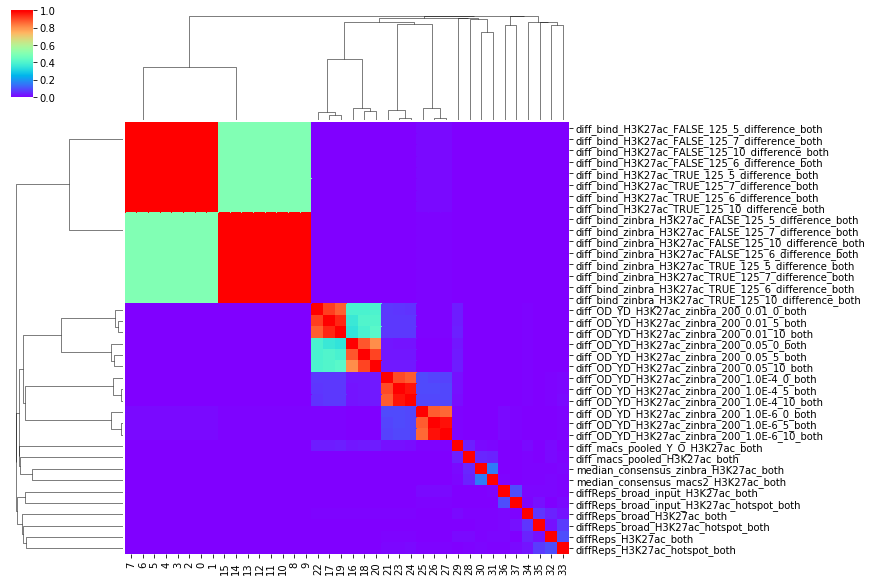

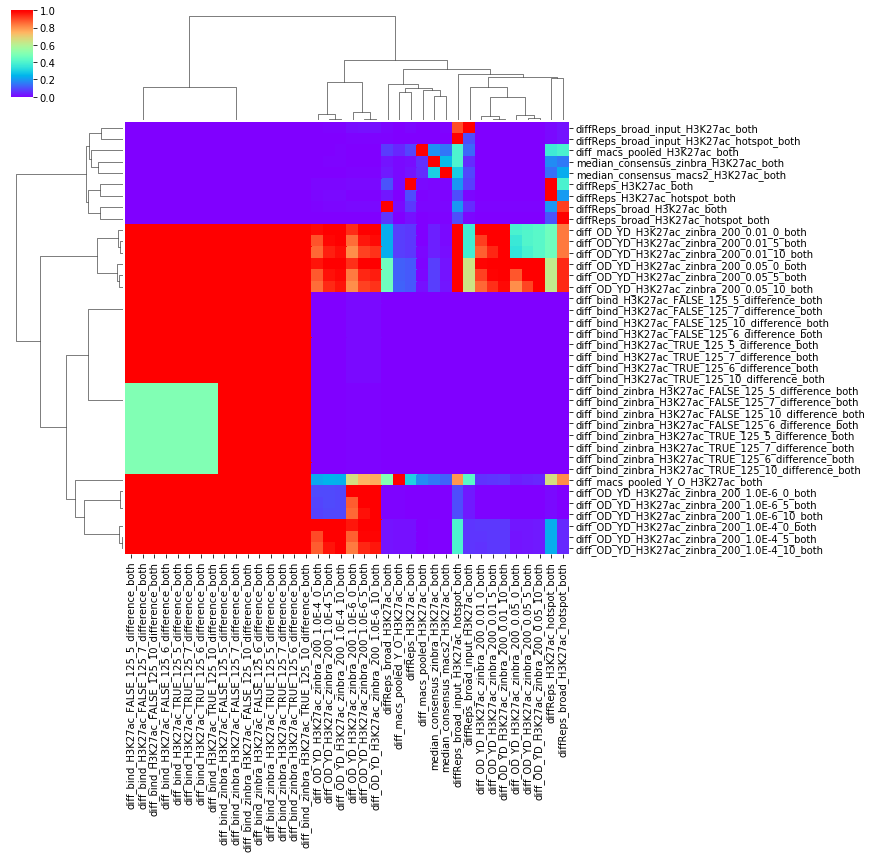

In [8]:
do_plot("jaccard")
do_plot("m1")

In [9]:
diffs.get_bed_files_produced()

['diff_bind_H3K27ac_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_5_difference_both.bed',
 'diff_OD_YD_H3K27ac_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K27ac_zinbra_200_0.

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed >/tmp/tmpwgh4t1ww.tmp/counts.bed


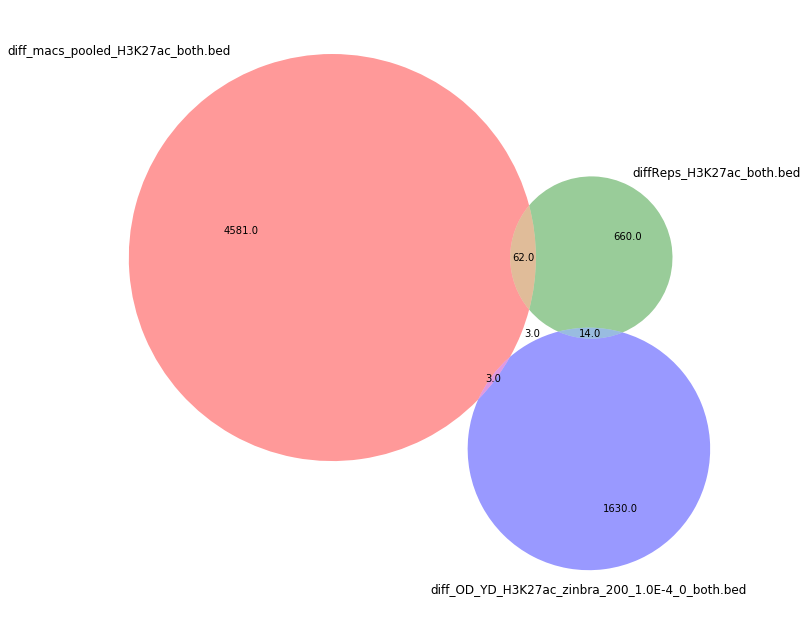

In [10]:
diffs.plot_venn3('diff_macs_pooled_H3K27ac_both.bed', 
                 'diffReps_H3K27ac_both.bed', 
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed >/tmp/tmplakf2t3r.tmp/counts.bed


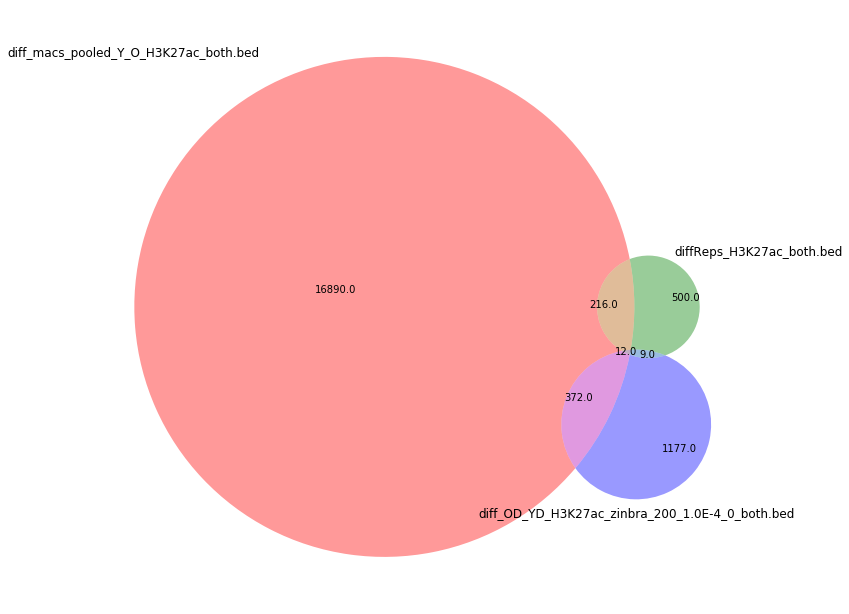

In [11]:
diffs.plot_venn3('diff_macs_pooled_Y_O_H3K27ac_both.bed', 
                 'diffReps_H3K27ac_both.bed', 
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_broad_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_5_both.bed >/tmp/tmpqh08jyp5.tmp/counts.bed


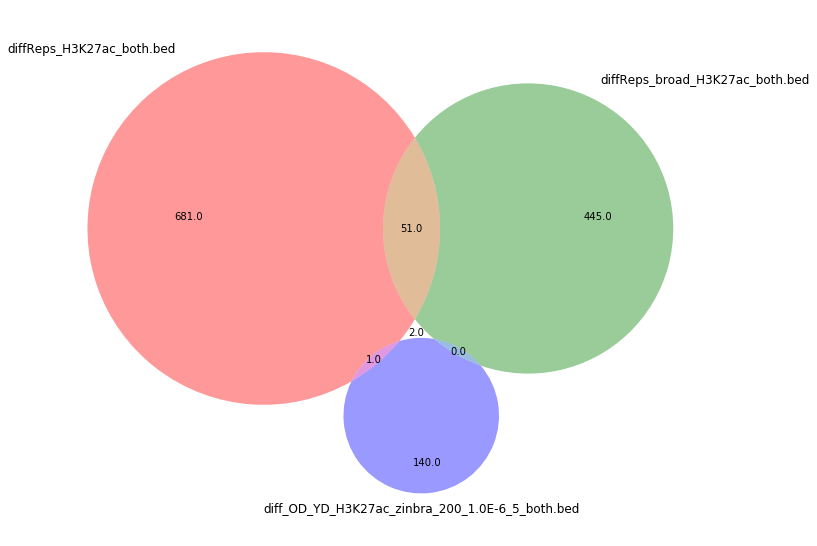

In [12]:
diffs.plot_venn3('diffReps_H3K27ac_both.bed', 
                 'diffReps_broad_H3K27ac_both.bed',
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_5_both.bed')

# H3K27me3

In [13]:
diffs = diffs_dict['H3K27me3']

In [14]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K27me3_TRUE_125_6_difference,0,0,0
1,diff_bind_H3K27me3_TRUE_125_10_difference,0,0,0
2,diff_bind_H3K27me3_TRUE_125_7_difference,0,0,0
3,diff_bind_H3K27me3_TRUE_125_5_difference,0,0,0
4,diff_bind_H3K27me3_FALSE_125_6_difference,2,2,0
5,diff_bind_H3K27me3_FALSE_125_10_difference,2,2,0
6,diff_bind_H3K27me3_FALSE_125_7_difference,2,2,0
7,diff_bind_H3K27me3_FALSE_125_5_difference,3,3,0
8,diff_bind_zinbra_H3K27me3_TRUE_125_6_difference,5,1,4
9,diff_bind_zinbra_H3K27me3_TRUE_125_10_difference,5,1,4


/tmp/tmp6s8wr9vd.tmp


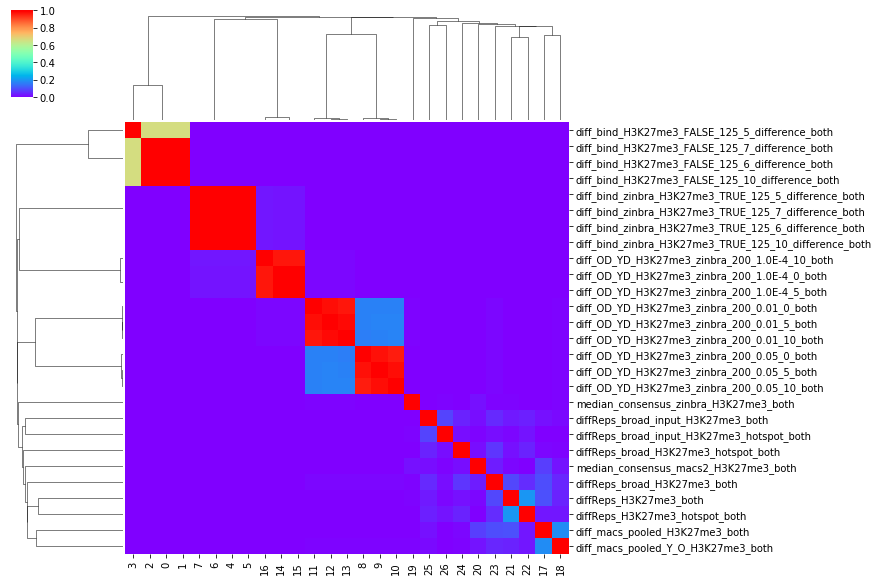

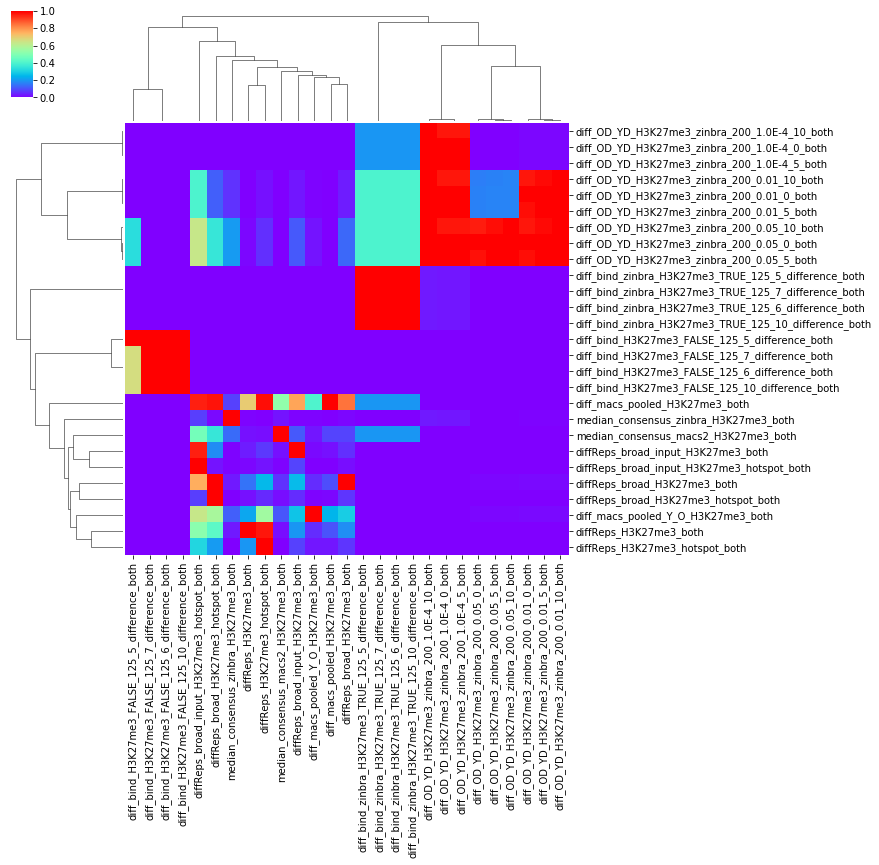

In [15]:
intersection = diffs.count_intersections()

do_plot("jaccard")
do_plot("m1")

In [16]:
diffs.get_bed_files_produced()

['diff_bind_H3K27me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_5_difference_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.05_5_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.05_10_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_10_both.bed',
 'diff_macs_pooled_H3K27me3_both.bed',
 'diff_macs_pooled_Y_O_H3K2

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmpbs1bb_5d.tmp/counts.bed


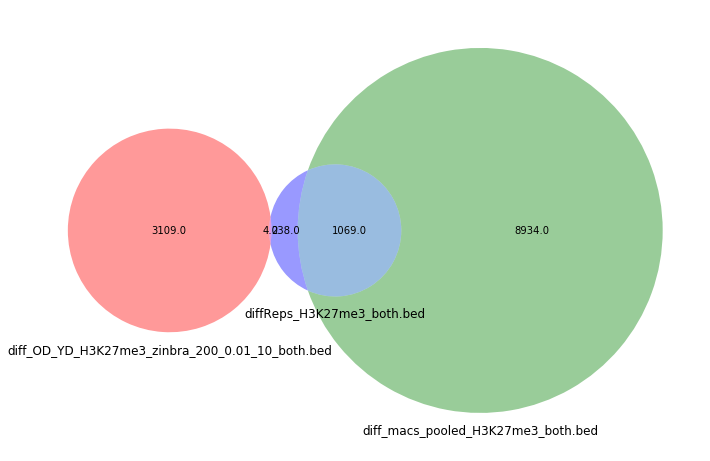

In [18]:
diffs.plot_venn3('diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed', 
                 'diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmpejwwxiu9.tmp/counts.bed


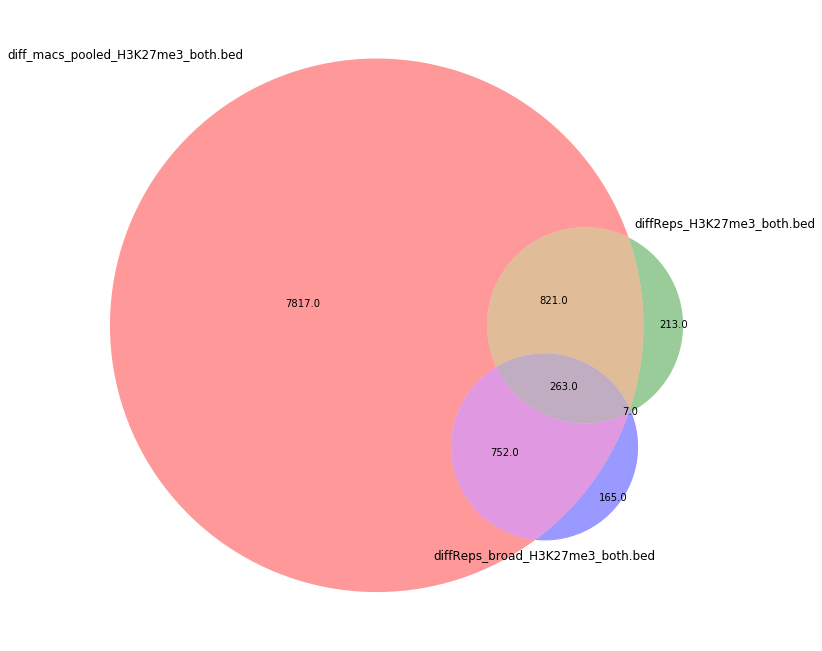

In [19]:
diffs.plot_venn3('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmp7kfkv_8l.tmp/counts.bed
0


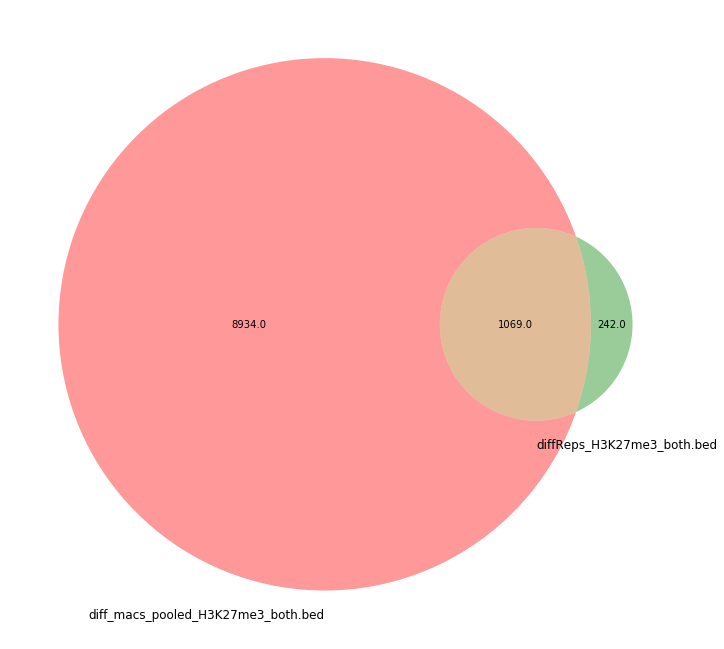

In [20]:
diffs.plot_venn2('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_OD_YD_H3K27me3_zinbra_200_0.05_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_Y_O_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmpzrnmr6yj.tmp/counts.bed


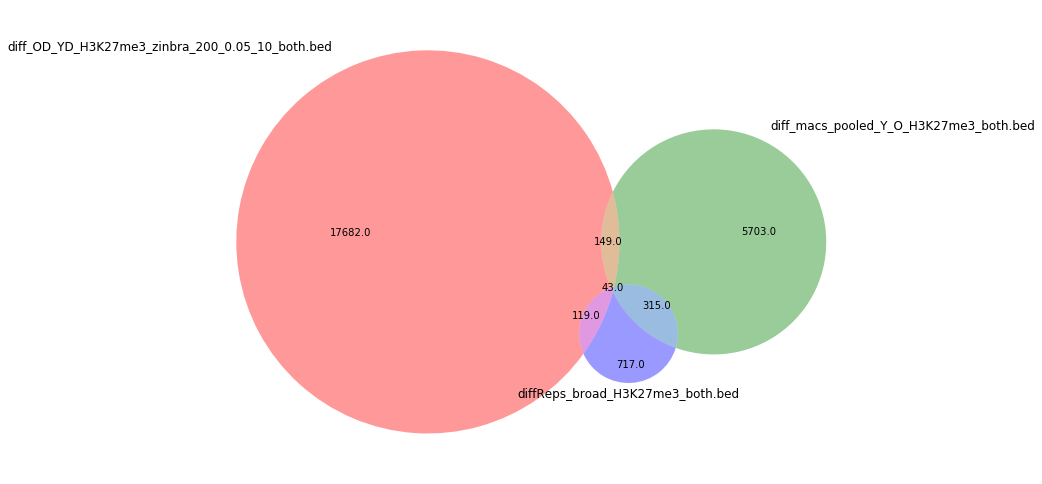

In [21]:
diffs.plot_venn3('diff_OD_YD_H3K27me3_zinbra_200_0.05_10_both.bed', 
                 'diff_macs_pooled_Y_O_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

## H3K4me1

In [22]:
diffs = diffs_dict['H3K4me1']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K4me1_TRUE_125_6_difference,2,0,2
1,diff_bind_H3K4me1_TRUE_125_10_difference,2,0,2
2,diff_bind_H3K4me1_TRUE_125_7_difference,2,0,2
3,diff_bind_H3K4me1_TRUE_125_5_difference,2,0,2
4,diff_bind_H3K4me1_FALSE_125_6_difference,0,0,0
5,diff_bind_H3K4me1_FALSE_125_10_difference,0,0,0
6,diff_bind_H3K4me1_FALSE_125_7_difference,0,0,0
7,diff_bind_H3K4me1_FALSE_125_5_difference,0,0,0
8,diff_bind_zinbra_H3K4me1_TRUE_125_6_difference,2,0,2
9,diff_bind_zinbra_H3K4me1_TRUE_125_10_difference,2,0,2


/tmp/tmpzc4yw5zx.tmp


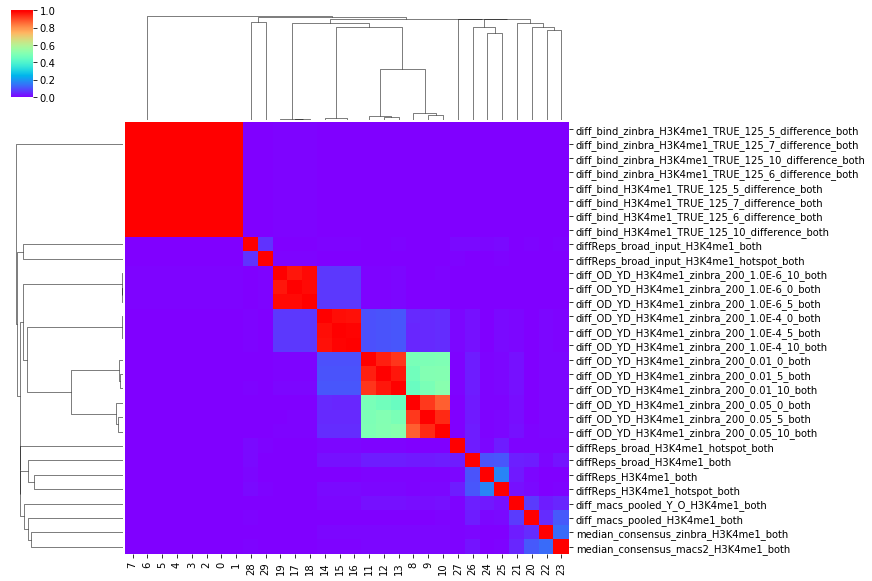

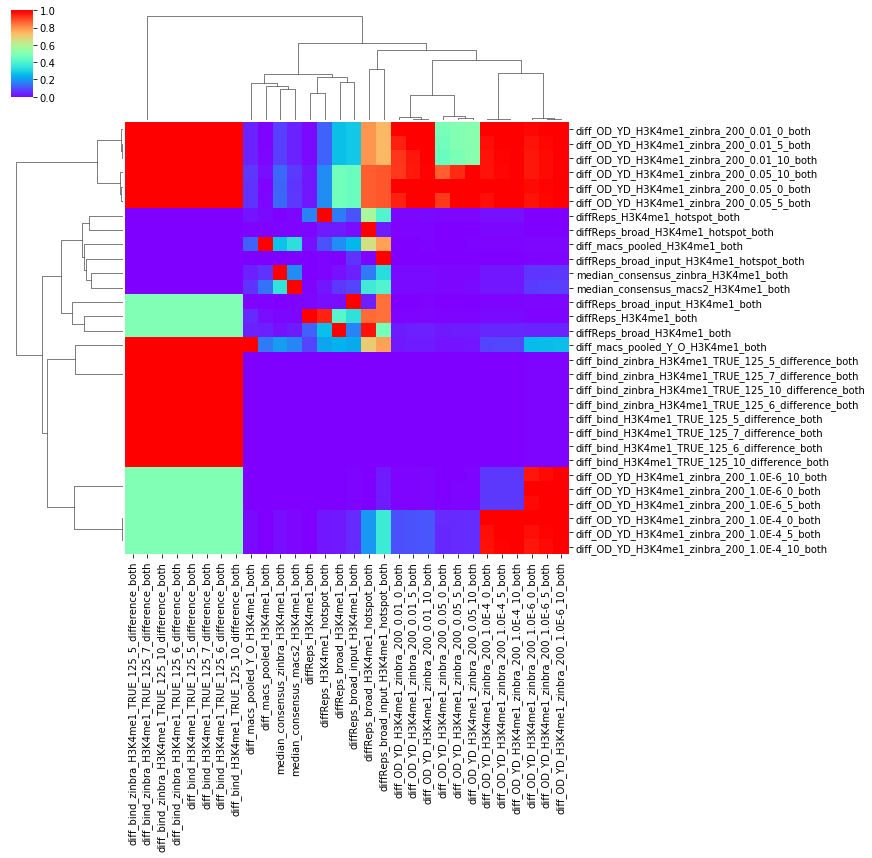

In [23]:
intersection = diffs.count_intersections()

do_plot("jaccard")
do_plot("m1")

In [24]:
diffs.get_bed_files_produced()

['diff_bind_H3K4me1_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_5_difference_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_macs_pooled_Y_O_H3K4me1_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diffReps_H3K4me1_both.bed >/tmp/tmpnxa_ev9q.tmp/counts.bed


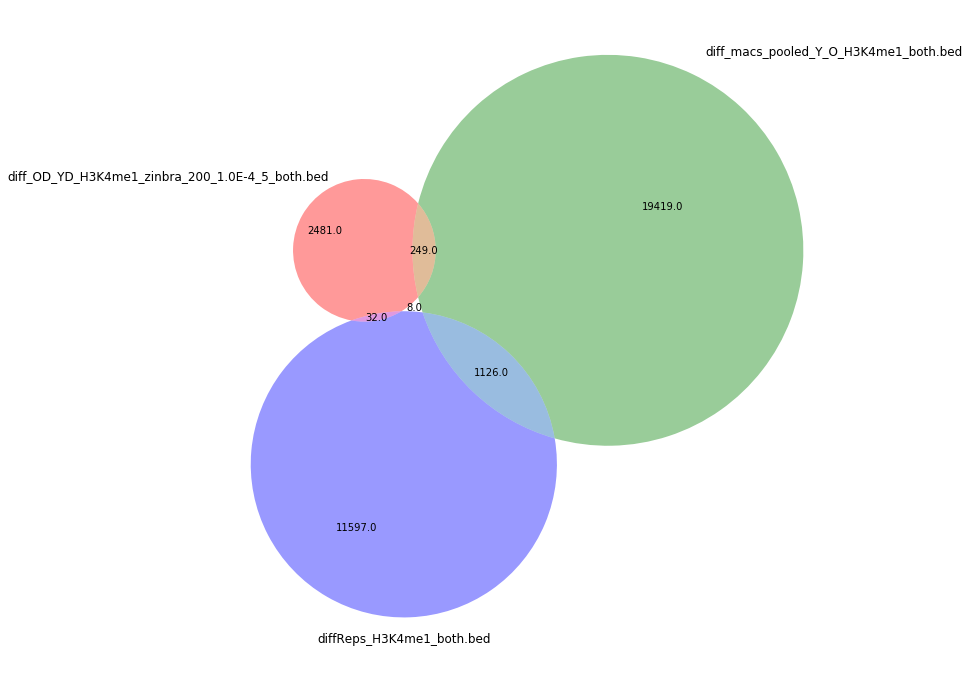

In [25]:
diffs.plot_venn3('diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed', 
                 'diff_macs_pooled_Y_O_H3K4me1_both.bed',
                 'diffReps_H3K4me1_both.bed')

## H3K4me3

In [26]:
diffs = diffs_dict['H3K4me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K4me3_TRUE_125_6_difference,30,29,1
1,diff_bind_H3K4me3_TRUE_125_10_difference,30,29,1
2,diff_bind_H3K4me3_TRUE_125_7_difference,30,29,1
3,diff_bind_H3K4me3_TRUE_125_5_difference,32,31,1
4,diff_bind_H3K4me3_FALSE_125_6_difference,489,488,1
5,diff_bind_H3K4me3_FALSE_125_10_difference,489,488,1
6,diff_bind_H3K4me3_FALSE_125_7_difference,489,488,1
7,diff_bind_H3K4me3_FALSE_125_5_difference,489,488,1
8,diff_bind_zinbra_H3K4me3_TRUE_125_6_difference,1448,1446,2
9,diff_bind_zinbra_H3K4me3_TRUE_125_10_difference,1448,1446,2


/tmp/tmpp_j2jk2a.tmp


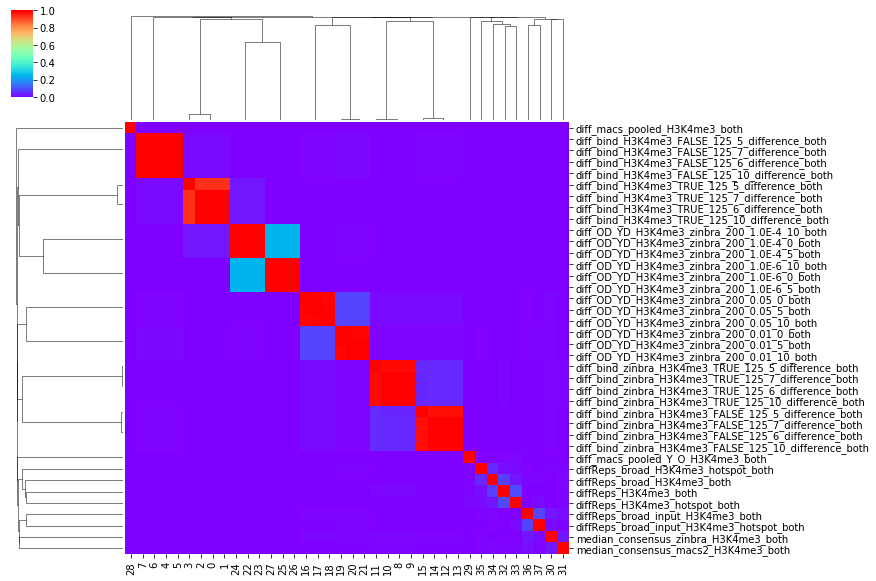

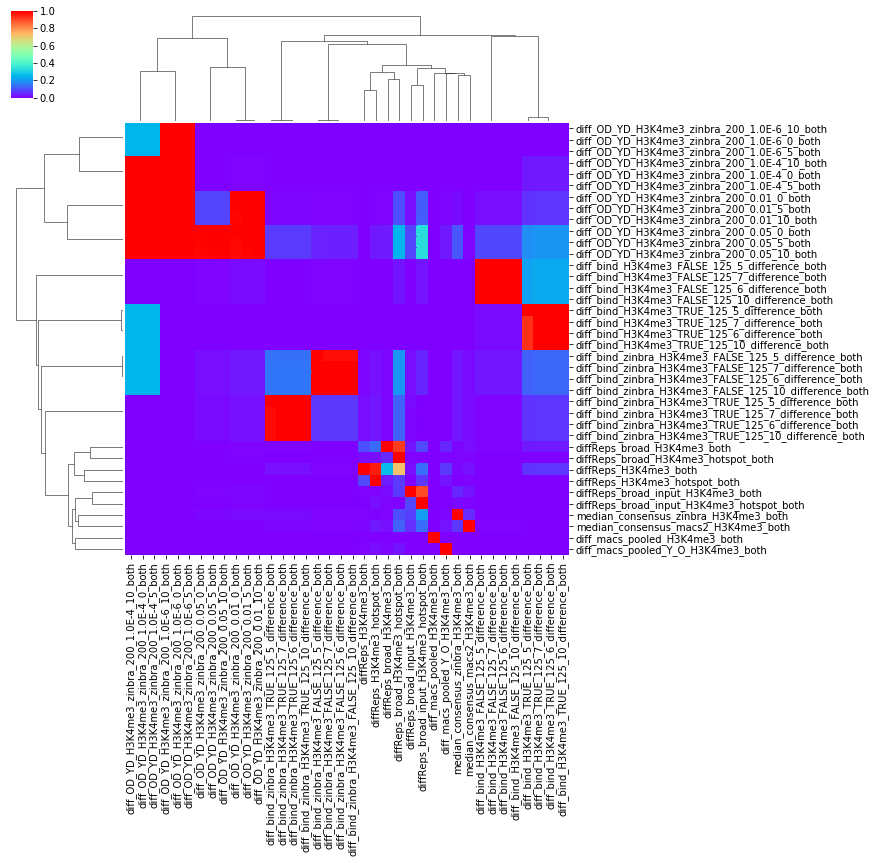

In [27]:
intersection = diffs.count_intersections()

do_plot("jaccard")
do_plot("m1")

In [28]:
diffs.get_bed_files_produced()

['diff_bind_H3K4me3_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_5_difference_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_0.

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diffReps_H3K4me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_macs_pooled_Y_O_H3K4me3_both.bed >/tmp/tmpg0vldvp_.tmp/counts.bed


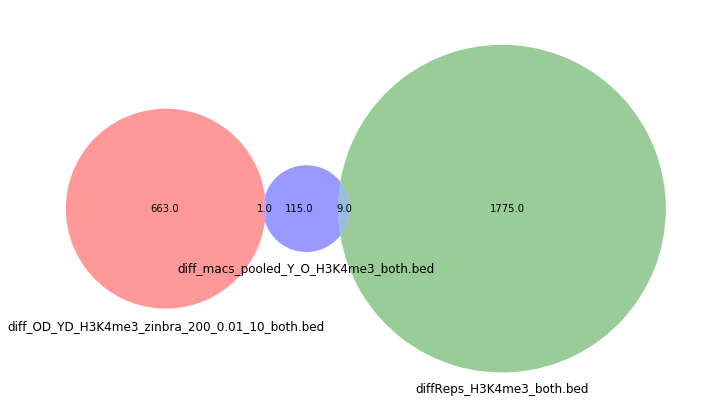

In [30]:
diffs.plot_venn3('diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed', 
                 'diffReps_H3K4me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K4me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_OD_YD_H3K4me3_zinbra_200_0.05_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diffReps_broad_H3K4me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_macs_pooled_Y_O_H3K4me3_both.bed >/tmp/tmpp0nwtztp.tmp/counts.bed


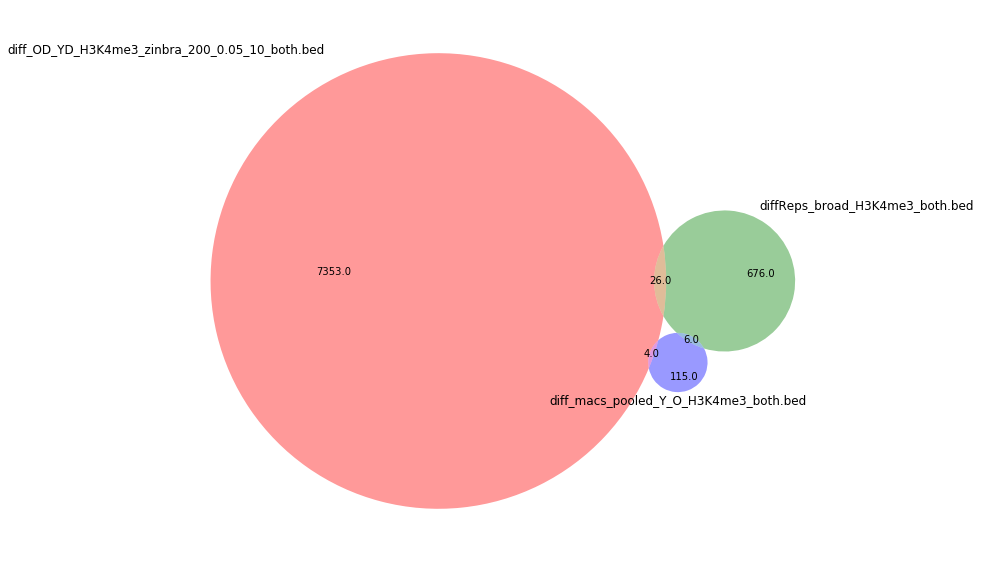

In [31]:
diffs.plot_venn3('diff_OD_YD_H3K4me3_zinbra_200_0.05_10_both.bed', 
                 'diffReps_broad_H3K4me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K4me3_both.bed')

## H3K36me3

In [32]:
diffs = diffs_dict['H3K36me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K36me3_TRUE_125_6_difference,7,0,7
1,diff_bind_H3K36me3_TRUE_125_10_difference,7,0,7
2,diff_bind_H3K36me3_TRUE_125_7_difference,7,0,7
3,diff_bind_H3K36me3_TRUE_125_5_difference,7,0,7
4,diff_bind_H3K36me3_FALSE_125_6_difference,2,0,2
5,diff_bind_H3K36me3_FALSE_125_10_difference,2,0,2
6,diff_bind_H3K36me3_FALSE_125_7_difference,2,0,2
7,diff_bind_H3K36me3_FALSE_125_5_difference,2,0,2
8,diff_bind_zinbra_H3K36me3_TRUE_125_6_difference,2,0,2
9,diff_bind_zinbra_H3K36me3_TRUE_125_10_difference,2,0,2


/tmp/tmpkzw6bt68.tmp


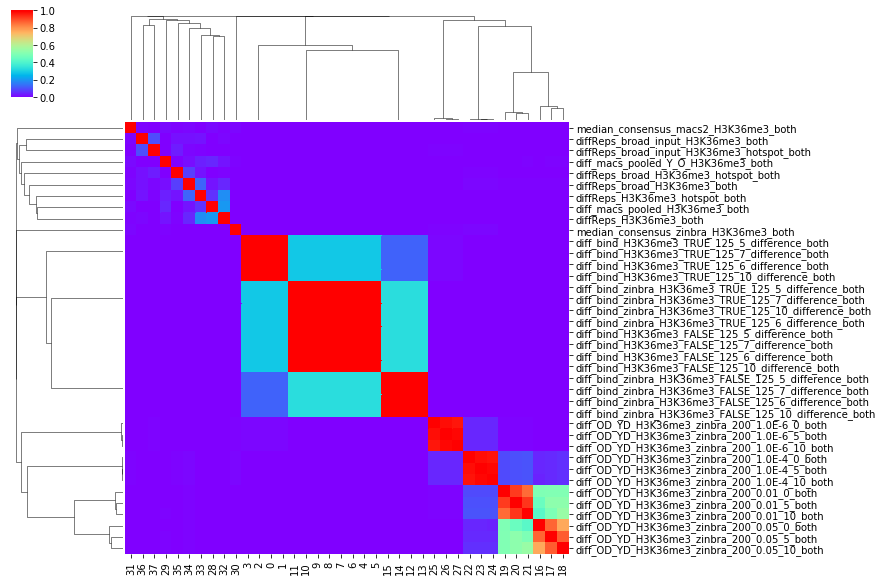

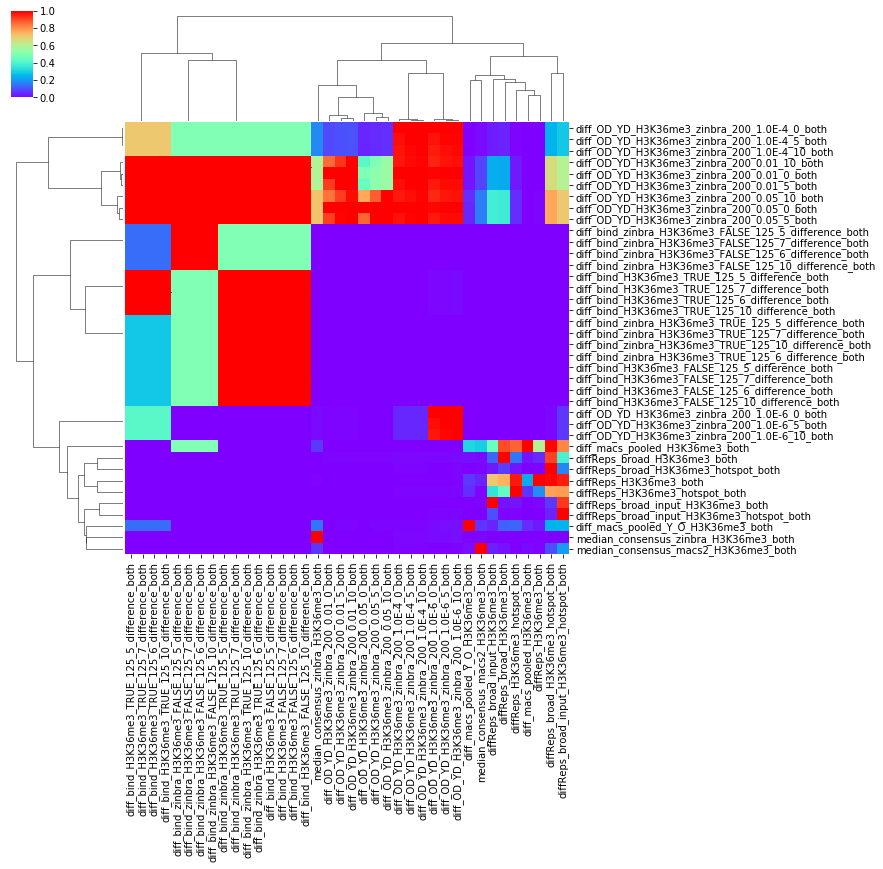

In [33]:
intersection = diffs.count_intersections()

do_plot("jaccard")
do_plot("m1")

In [34]:
diffs.get_bed_files_produced()

['diff_bind_H3K36me3_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_5_difference_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K3

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diffReps_H3K36me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmpb6ckdwhj.tmp/counts.bed


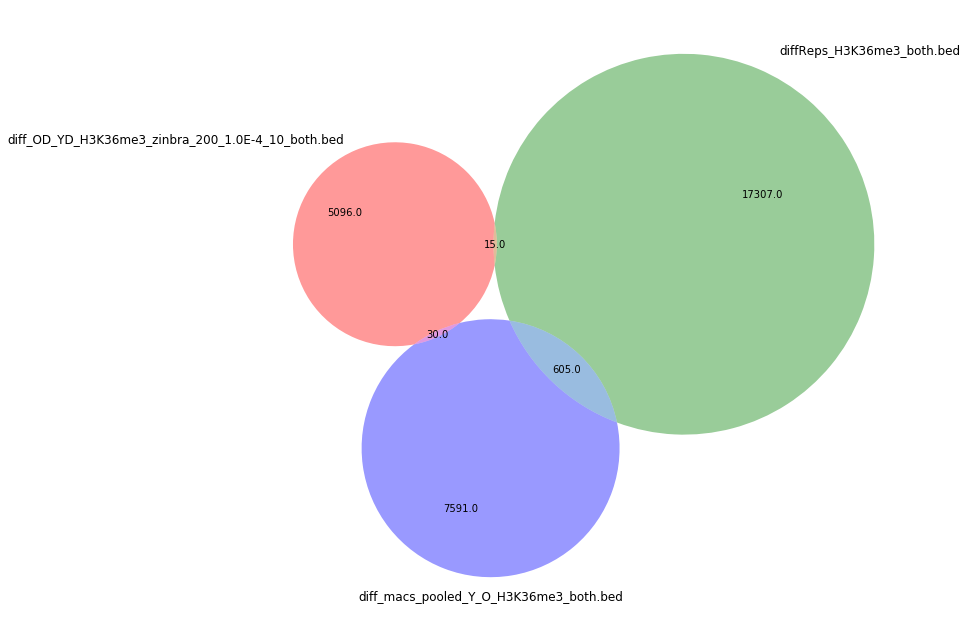

In [38]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed', 
                 'diffReps_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diffReps_broad_H3K36me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmp_qu7p4js.tmp/counts.bed


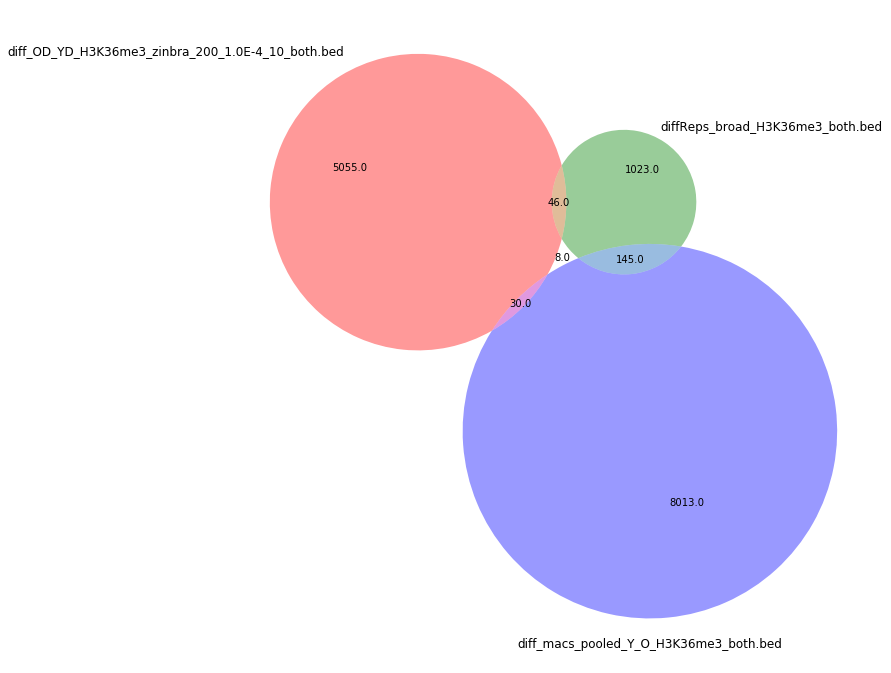

In [39]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
                 'diffReps_broad_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')